In [91]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

print("Imports completed successfully.")

Imports completed successfully.


In [92]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [93]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [94]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [95]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [96]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    batch_losses = []  # create list to store losses
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_losses.append(loss.item())  # store loss

        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")
    
    return batch_losses  # <-- this line is required!


In [97]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [98]:
import matplotlib.pyplot as plt

all_losses = []

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    batch_losses = train(train_dataloader, model, loss_fn, optimizer)
    all_losses.extend(batch_losses)  # store batch losses
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.314933  [   64/60000]
loss: 2.301591  [ 6464/60000]
loss: 2.285085  [12864/60000]
loss: 2.268321  [19264/60000]
loss: 2.256714  [25664/60000]
loss: 2.229537  [32064/60000]
loss: 2.233933  [38464/60000]
loss: 2.204242  [44864/60000]
loss: 2.202199  [51264/60000]
loss: 2.160149  [57664/60000]
Test Error: 
 Accuracy: 35.0%, Avg loss: 2.165853 

Epoch 2
-------------------------------
loss: 2.184725  [   64/60000]
loss: 2.176455  [ 6464/60000]
loss: 2.123646  [12864/60000]
loss: 2.127250  [19264/60000]
loss: 2.090680  [25664/60000]
loss: 2.022162  [32064/60000]
loss: 2.054445  [38464/60000]
loss: 1.979784  [44864/60000]
loss: 1.987079  [51264/60000]
loss: 1.908355  [57664/60000]
Test Error: 
 Accuracy: 54.8%, Avg loss: 1.917479 

Epoch 3
-------------------------------
loss: 1.955603  [   64/60000]
loss: 1.930057  [ 6464/60000]
loss: 1.820605  [12864/60000]
loss: 1.846519  [19264/60000]
loss: 1.755294  [25664/60000]
loss: 1.689479  [32064/600

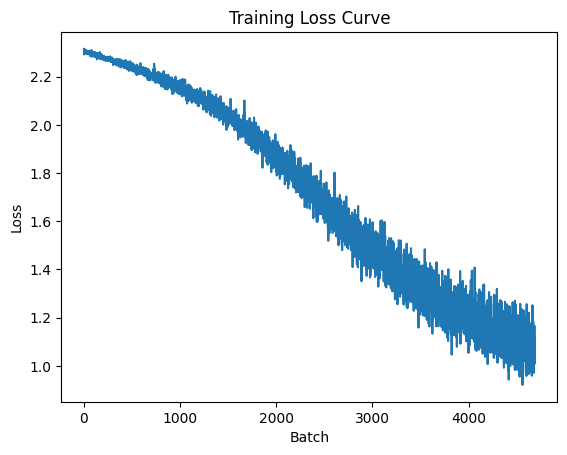

In [99]:
plt.plot(all_losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()
